<br>
<center>
<h1>Workforce Analytics</h1>
<h2><i> - Seongmin Lee(CID: 01247436)  -</i></h2>

# Preprocessing & Feature Engineering

In the previous section, the data relevant to the publications' cited time has been scraped on the Web of Science. The size of the paper is 1421, which are enough to be representative to measure the publications performance written by the professors at the business school of Imperial College London. Based on the preprocessing of those datasets, features to predict the cited items will be generated in this section. The file name of the base dataset is the WOS_scraped_df_ver3, which includes the necessary and essential information on each publication, such as title, authors, cited time, and published year. And the other datasets such as authors, references, journals, and research categories will be merged into the base dataset and re-formulated to new features.

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import requests
import re
import sys
import io
import time
import math
from collections import Counter
import datetime
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)

In [6]:
# Base dataset
WOS_df = pd.read_pickle('./data/WOS_scraped_df_ver3.pkl')
WOS_df.head(2)

,WOS_URL,Title,co_author1,co_author2,journal_type,research_areas,WOS_cate,address,organization,date,cited_time,num_of_ref,abstract,keywords,publisher
0,http://gateway.webofknowledge.com/gateway/Gate...,Nelson-Plosser revisited: The ACF approach,"[abadir, km, caggiano, g, talmain, g]","[Abadir, Karim M, Caggiano, Giovanni, Talmain,...",JOURNAL OF ECONOMETRICS,"[Business & Economics, Mathematics, Mathemat...","[Economics, Mathematics, Interdisciplinary Ap...","[Univ Glasgow, Glasgow G QQ, Lanark, Scotland,...","[Imperial College London, University of Glasgo...",13-Jul,5,42,We detect a new stylized fact that is common t...,"[MACROECONOMIC TIME-SERIES, LONG-MEMORY, STOCK...","ELSEVIER SCIENCE SA, PO BOX 564, 1001 LAUSANNE..."
1,http://gateway.webofknowledge.com/gateway/Gate...,An I(d) model with trend and cycles,"[abadir, km, distaso, w, giraitis, l]","[Abadir, Karim M, Distaso, Walter, Giraitis, L...",JOURNAL OF ECONOMETRICS,"[Business & Economics, Mathematics, Mathemat...","[Economics, Mathematics, Interdisciplinary Ap...","[Univ London, Dept Econ, London E NS, England,...","[Imperial College London, University of London]",11-Aug,5,22,This paper deals with models allowing for tren...,"[LONG-RANGE DEPENDENCE, MEMORY STATIONARY ERRO...","ELSEVIER SCIENCE SA, PO BOX 564, 1001 LAUSANNE..."


In [106]:
WOS_df.shape

(1421, 21)

## 1. Year since published

As depicted below, the longer the year of a publication is passed, the higher chances a paper gets to be cited. To control this factor, the "yrs_since_published" variable which is calculated by subtracting 2019 to published years is created.

In [7]:
# Call datetime class to now
now = datetime.datetime.now()

# By using regex, extract the numbers related to years
number_only = [''.join(re.findall(r'\d+', j)) for j in WOS_df.date]
year_only = [i[-2:] for i in number_only]

year_list = []
for y in year_only:
    if int(y) > int(str(now.year)[2:4]): # greater than 18
        year_list.append('19' + y)
    else:
        year_list.append('20'+ y)
WOS_df['published_yrs'] = year_list
WOS_df['yrs_since_published'] = [now.year - int(y) + 1 for y in year_list]

In [8]:
WOS_df[['Title', 'cited_time', 'yrs_since_published', 'published_yrs']].head(5)

,Title,cited_time,yrs_since_published,published_yrs
0,Nelson-Plosser revisited: The ACF approach,5,6,2013
1,An I(d) model with trend and cycles,5,8,2011
2,Two estimators of the long-run variance: Beyon...,9,10,2009
3,Testing joint hypotheses when one of the alter...,24,12,2007
4,Nonstationarity-extended local Whittle estimation,81,12,2007


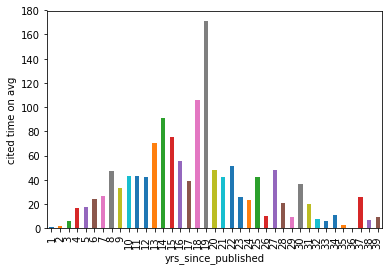

In [9]:
# Plot cited time on average by the period after being published
WOS_df.groupby('yrs_since_published').mean()['cited_time'].plot(kind = 'bar')
plt.ylabel('cited time on avg')
plt.show()

## 2. Organization Country (Preprocessing Only)

To measure diversity regarding the country, nation lists were extracted from the address column which includes the names of universities, address in details, and countries. The diversity features on organisations and nations will be generated in the latter section.

In [11]:
#Get the country name from the address column.
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

address_list = []
for i in list(WOS_df.address):
    add_unit = []
    for j in i:
        if 'USA' in j.split(',')[-1].strip().upper(): # MA USA -> USA
            add_unit.append('USA')
        elif j.split(',')[-1].strip().upper() in states:
            add_unit.append('USA')
        elif 'CHINA' in j.split(',')[-1].strip().upper(): # Peoples R China -> China
            add_unit.append('CHINA')
        else:
            add_unit.append(j.split(',')[-1].strip().upper()) 
    if len(add_unit) == 0:
        address_list.append(['ENGLAND'])
    else:
        address_list.append(list(add_unit))
        
WOS_df['organ_country'] = address_list

In [12]:
WOS_df[['Title', 'cited_time', 'address', 'organ_country']].head(5)

,Title,cited_time,address,organ_country
0,Nelson-Plosser revisited: The ACF approach,5,"[Univ Glasgow, Glasgow G QQ, Lanark, Scotland,...","[SCOTLAND, ENGLAND, ENGLAND, ITALY]"
1,An I(d) model with trend and cycles,5,"[Univ London, Dept Econ, London E NS, England,...","[ENGLAND, ENGLAND]"
2,Two estimators of the long-run variance: Beyon...,9,"[Univ London, Dept Econ, London E NS, England,...","[ENGLAND, ENGLAND]"
3,Testing joint hypotheses when one of the alter...,24,"[Univ London Imperial Coll Sci Technol Med, L...",[ENGLAND]
4,Nonstationarity-extended local Whittle estimation,81,"[Univ London Imperial Coll Sci Technol Med, T...","[ENGLAND, ENGLAND]"


## 3. Authors

### The number of the authors for each publication

The research outcome by AKSNES shows that the higher cited papers were written by a large number of co-authors(2003). Authors-related indicators are primary keys to measure the publications performance in that a publication written by authors with dominant reputation will be more likely to be read or cited by other authors. Above all, the number of the co-authors could be the simplest, but the most effective variable to be created. As shown on the bar chart, there is a tendency that the larger the number of co-authors is, the higher cited time the publications mostly acquire.

In [13]:
# The number of the authors for each publication
WOS_df['co_author_num'] = WOS_df['co_author1'].apply(lambda x:len(x))

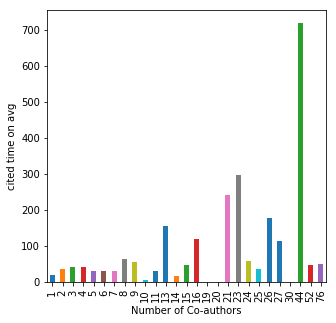

In [14]:
WOS_df.groupby('co_author_num').mean()['cited_time'].plot(kind = 'bar')
plt.xlabel('Number of Co-authors')
plt.ylabel('cited time on avg')
plt.show()

### Odd number of the authors (1 = odd-size group)

Menon and Phillips argued that the odd-sized groups perform better than the even-sized groups because the odd-sized groups have higher coalition due to not being evenly balanced, which mostly draws the better results(2011). Therefore, I created the dummy labelled as one if either the number of the group member is odd and not a single author. As depicted below, the odd-sized group mostly gets the higher number of citation than the even sized group and a group of single authors.

In [15]:
WOS_df['author_odd_num_dummy'] = np.where(np.logical_or((WOS_df['co_author_num']%2 == 0), (WOS_df['co_author_num'] == 1 )), 0, 1)

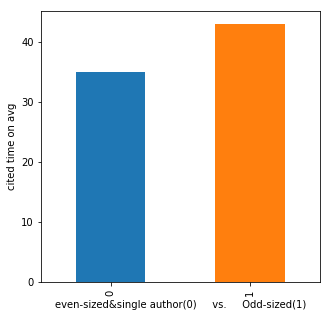

In [16]:
WOS_df.groupby('author_odd_num_dummy').mean()['cited_time'].plot(kind = 'bar')
plt.xlabel('even-sized&single author(0)     vs.     Odd-sized(1)')
plt.ylabel('cited time on avg')
plt.show()

### The average h index of the authors

The author.csv file displays each author's performance in term of publication history. Among the achievement indicators, h-index is typical of measurement to authors' productivity. Therefore, the h index on average in the group of the authors for a publication is calculated as a metric of the publications performance. As shown in the below chart, the documents with the higher h index on average occupy on the upper right, which indicates the h index on average could be a proper metric to evaluate publications quality.

In [17]:
# Author Information
authors_info = pd.read_csv('./data/Author.csv')
authors_info.drop(columns = ['publication_url', 'authors_url'], axis = 1).head(5)

,name,name_id,ttl_publication,h-index,avg_citation_per_item,sum_of_times_cited,without_self_citations,citing_articles,without_self_citations_article
0,"Cosh, A","cosh, a",8,7,42.63,341,339,330,328
1,"Hughes, A","hughes, a",39,17,32.54,1269,1257,1211,1202
2,"Toms, S","toms, s",58,12,7.78,451,380,349,322
3,"Wright, M","wright, m",318,68,49.07,15603,14181,9245,8992
4,"Calzada, Joan","calzada, j",21,8,6.48,136,129,128,122


In [18]:
# By looping a list of the co-authors, calculate a mean of h-index
avg_author_h_index = []
for row, authors in enumerate(list(WOS_df.co_author1)):
    h_index = 0
    count = 0
    for idx in range(len(authors)):
        ind = authors_info[authors_info.name_id == str(authors[idx])].index[0]
        h_index += float(authors_info.loc[ind, ('h-index')])
        count+= 1
    avg_author_h_index.append(float(h_index)/float(count)) # average
WOS_df['avg_authors_h_index'] = avg_author_h_index

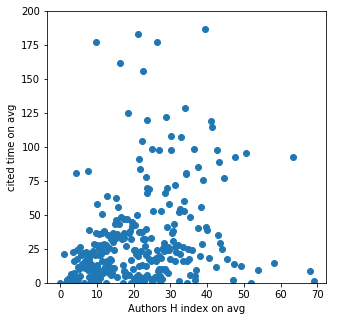

In [19]:
author_sub = WOS_df.groupby('avg_authors_h_index').mean()['cited_time'].reset_index()
plt.scatter(x = list(author_sub.avg_authors_h_index), y = list(author_sub.cited_time))
plt.xlabel('Authors H index on avg')
plt.ylabel('cited time on avg')
plt.ylim(0, 200)
plt.show()

In [20]:
WOS_df[['Title', 'cited_time', 'avg_authors_h_index', 'co_author_num']].head(5)

,Title,cited_time,avg_authors_h_index,co_author_num
0,Nelson-Plosser revisited: The ACF approach,5,6.333333,3
1,An I(d) model with trend and cycles,5,7.333333,3
2,Two estimators of the long-run variance: Beyon...,9,7.333333,3
3,Testing joint hypotheses when one of the alter...,24,6.000000,2
4,Nonstationarity-extended local Whittle estimation,81,4.333333,3


## 4. Reference

According to an article in Nature, the number of the reference in a publication is highly related to the cited time (Corbyn, 2010). Corbyn demonstrated that a writer citing a peer expert output is expected to be quoted from the cited author. Not only that, but quoting is a logical way for an article to strengthen argument on controvertible issues. So, the longer list of reference an article has, the more likely the article is to be irrefutable. The base dataset already includes the number of the reference in each publication. In the Reference.csv dataset, we have reference title and year of being published and cited times for each paper in the base dataset. Calculated the cited time on average for the whole reference in each publication, a new feature is created to describe that how irrefutable the article is.

In [21]:
# Reference Information
ref = pd.read_csv('./data/Reference.csv')
ref = ref[ref.ref_year != 'no_reference'] #delete the no reference lines
ref.drop(columns = ['publication_url'], axis =1).head(5)

,citing_title,citing_year,ref_title,ref_year,ref_times_cited
0,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,18-Apr,What is not a real option: Considering boundar...,04-Jan,222
1,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,18-Apr,Match your innovation strategy to your innovat...,06-Apr,247
2,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,18-Apr,NaN,2012,14
3,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,18-Apr,INTRODUCTION: COLLABORATION AND COMPETITION IN...,2013,2
4,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,18-Apr,Innovation ecosystems and the pace of substitu...,16-Apr,26


In [22]:
print('The number of the missing values in the ref_year column:', ref.isnull().sum()['ref_year'])

The number of the missing values in the ref_year column: 371


### Web-scraping the google scholar to fill the na values in the "ref_year" column

In [23]:
# filter the na values in the ref_year column
na_ref_year_df = ref[(ref.ref_year.isnull() == True) & (ref.ref_title.isnull() == False)]
na_ref_year_df[['citing_title', 'ref_title', 'ref_year']].head(5)

,citing_title,ref_title,ref_year
3545,Knowledge Worker Mobility in Context: Pushing ...,"Social ties, prior experience, and venture cre...",NaN
3937,Toward an integrated approach to nutritional q...,Access to adequate food: new indicators to tra...,NaN
3946,Toward an integrated approach to nutritional q...,The Implications of a changing climate on glob...,NaN
5043,Game On? Smoking Cessation Through the Gamific...,Qual Res Psychol Internet,NaN
5327,Equity impacts of price policies to promote he...,Responding to the challenge of resource mobili...,NaN


In [24]:
# Web-scarape the google scholar to parse the year of being pusblished in each referenced ariticles
year_list = []
chrome_options = Options()
chrome_options.add_argument('--lang=en-us')
driver = webdriver.Chrome(chrome_options=chrome_options,executable_path=r"C:/Users/seong/Downloads/chrome/chromedriver")

#Search the titles of the references and parsing the year
for title in list(na_ref_year_df.ref_title):
    driver.get('https://scholar.google.co.uk/schhp?hl=en&as_sdt=0,5')
    driver.implicitly_wait(5)
    driver.find_element_by_xpath('//*[@id="gs_hdr_tsi"]').send_keys(title)
    driver.implicitly_wait(5)
    driver.find_element_by_xpath('//*[@id="gs_hdr_tsb"]/span/span[1]').click()
    driver.implicitly_wait(5)
    web_soup = BeautifulSoup(driver.page_source, "html.parser")
    time.sleep(5)
    year_parsing = web_soup.select_one('div.gs_a').text
    try:
        year = int(re.findall(r'\d+', year_parsing)[0])
    except:
        year = np.nan
    year_list.append(year)
driver.quit()

na_ref_year_df['ref_year'] = year_list

# Manually adding by searching
na_ref_year_df.loc[5043, 'ref_year'] = 2016.0

In [25]:
#Fill the na values in the ref dataframe with the scraped date string
for ind in list(na_ref_year_df.index):
    ref.loc[ind, 'ref_year'] = na_ref_year_df.loc[ind, 'ref_year']

In [26]:
print('The number of the missing values in the ref_year column:', ref.isnull().sum()['ref_year'])

The number of the missing values in the ref_year column: 284


### Preprocessing the date strings to extract the year only

In [27]:
not_null_ref = ref[ref.ref_year.isnull() == False]
not_null_ref.ref_year = not_null_ref.ref_year.astype(str)

number_only = [''.join(re.findall(r'\d+', j)) for j in list(not_null_ref.ref_year)] #extract only decimal
year_only = [i[-2:] for i in number_only] #extract the last two digits
year_list = []
for y in year_only:
    if int(y) > int(str(now.year)[2:4]): # greater than 18
        year_list.append('19' + y)
    else:
        year_list.append('20'+ y)
not_null_ref['ref_year'] = year_list  

for ind in list(not_null_ref.index):
    ref.loc[ind, 'refined_year'] = not_null_ref.loc[ind, 'ref_year']

### Fill the na values in the ref_year column with the references' year on average in each publication

In [28]:
for url in list(ref.publication_url.unique()): # url is a primary key to find a dataline in the base data
    url_group_year = ref[ref.publication_url == url] # filter one journal
    try:
        na_list_index = url_group_year[url_group_year.refined_year.isnull()].index #extract the index of having na on year of publishment
        mean_year_of_group = url_group_year[url_group_year.refined_year.isnull() == False]['refined_year'].values.astype(int).mean().astype(int)
        ref.loc[list(na_list_index), 'refined_year'] = mean_year_of_group #fill na with the average year in the reference group
    except:
        continue # No na values, then continue the loop
               
ref.refined_year = ref.refined_year.astype(int)
ref.reset_index(inplace= True)

In [29]:
print('The number of the missing values in the ref_year column:', ref.isnull().sum()['refined_year'])

The number of the missing values in the ref_year column: 0


### Yearly Citation Number

In [30]:
# yearly_citation_num 
ref['yearly_citation_num'] = [int(ref.loc[i,'ref_times_cited'])/(now.year + 1 - ref.loc[i, 'refined_year']) for i in range(len(ref))]

In [31]:
ref[['citing_title', 'ref_title', 'ref_year', 'ref_times_cited', 'refined_year', 'yearly_citation_num']].head(5)

,citing_title,ref_title,ref_year,ref_times_cited,refined_year,yearly_citation_num
0,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,What is not a real option: Considering boundar...,04-Jan,222,2004,14.800000
1,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,Match your innovation strategy to your innovat...,06-Apr,247,2006,19.000000
2,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,NaN,2012,14,2012,2.000000
3,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,INTRODUCTION: COLLABORATION AND COMPETITION IN...,2013,2,2013,0.333333
4,MANEUVERING IN POOR VISIBILITY: HOW FIRMS PLAY...,Innovation ecosystems and the pace of substitu...,16-Apr,26,2016,8.666667


### Group by each publication, and summate the yearly citation number with the relevant references

In [32]:
ref_url_groupby = ref.groupby('publication_url').mean()['yearly_citation_num'].reset_index()
ref_url_groupby.rename(columns={'yearly_citation_num':'ref_yearly_cited_avg'}, inplace= True)

### Merge the ref dataframe with the WOS_df dataframe

In [33]:
# Merge key = publication URL on the Web of Science
merged_WOS_df = WOS_df.merge(right = ref_url_groupby, how = 'left', left_on = ['WOS_URL'], right_on = ['publication_url'])
merged_WOS_df['ref_yearly_cited_avg'] = merged_WOS_df['ref_yearly_cited_avg'].fillna(value=0)
merged_WOS_df.drop(columns=['publication_url'], axis=1, inplace=True)

In [34]:
merged_WOS_df[['Title', 'ref_yearly_cited_avg', 'num_of_ref', 'cited_time']].head(5)

,Title,ref_yearly_cited_avg,num_of_ref,cited_time
0,Nelson-Plosser revisited: The ACF approach,18.801852,42,5
1,An I(d) model with trend and cycles,3.940034,22,5
2,Two estimators of the long-run variance: Beyon...,26.560935,21,9
3,Testing joint hypotheses when one of the alter...,10.841103,58,24
4,Nonstationarity-extended local Whittle estimation,6.388188,21,81


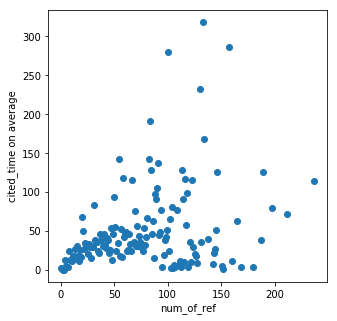

In [114]:
ref_sub = merged_WOS_df.groupby('num_of_ref').mean()['cited_time'].reset_index()
plt.scatter(x = list(ref_sub.num_of_ref), y = list(ref_sub.cited_time))
plt.xlabel('num_of_ref')
plt.ylabel('cited_time on average')
plt.show()

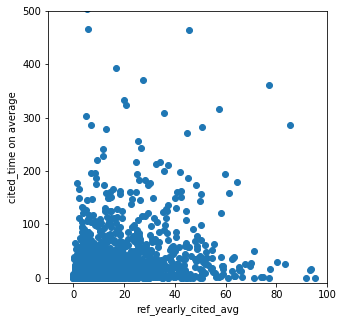

In [115]:
ref_sub2 = merged_WOS_df.groupby('ref_yearly_cited_avg').mean()['cited_time'].reset_index()
plt.scatter(x = list(ref_sub2.ref_yearly_cited_avg), y = list(ref_sub2.cited_time))
plt.xlabel('ref_yearly_cited_avg')
plt.ylabel('cited_time on average')
plt.ylim(-10, 500)
plt.xlim(-10, 100)
plt.show()

## 5. Organization

Most of the co-authors belonged to certain official organisations when they published the papers. The quality of the publications has an effect on the university rankings. Reversely, the institution's level might help to form a group of competent authors or more likely to secure the funding. The dataset in the organizationbyResearchArea folder contains category normalised impact factors and ranking by each research field and universities as shown below. According to the indicator handbook on Web of Science, "The Category Normalized Citation Impact (CNCI) of a document is calculated by dividing the actual count of citing items by the expected citation rate for documents with the same document type, year of publication and subject area" (InCites INDICATORS HANDBOOK, 2014, p.11.). Therefore, the organization ranking and category normalized citation impact on average in each research field has been aggregated for each publication. As shown in the below charts, the both variables seems relevant to the cited time.

In [37]:
print("=== Research Field: Anesthesiology ===")
pd.read_csv('./data/organizationbyResearchArea/Anesthesiology.csv').head(5)

=== Research Field: Anesthesiology ===


,Name,Rank,Web of Science Documents,Category Normalized Citation Impact,Times Cited,% Docs Cited
0,University of California System,1.0,6276.0,1.45,136231.0,72.34
1,Harvard University,2.0,5845.0,1.33,105297.0,70.88
2,University of California San Francisco,3.0,2814.0,1.62,74494.0,74.88
3,University of Toronto,4.0,3839.0,1.43,72983.0,74.58
4,University of London,5.0,3787.0,1.49,67801.0,69.26


In [38]:
#research field filter
re_area = []
for r_list in merged_WOS_df.WOS_cate:
    for r_ele in r_list:
        if not r_ele.strip() in re_area:
            re_area.append(r_ele.strip())
print("The number of the target research categories:", len(re_area))

The number of the target research categories: 94


### Category impact factor and  Ranking on average by a group of the institution in each publication

In [39]:
for idx, r_list in enumerate(list(merged_WOS_df.WOS_cate)): # list research fields
    ranking_avg = [] # initialize
    cate_impact_factor = [] # initialize
    for r_ele in r_list:  # loop each element of the research fields
        area_df = pd.read_csv('./data/organizationbyResearchArea/'+str(r_ele.strip())+'.csv') # access the indicators dataset in each field
        ranking = 0
        cate_i_f = 0
        count = 0
        for uni in list(merged_WOS_df.loc[idx, 'organization']): # loop the university list
            try:
                index_loc = area_df.Name[area_df.Name == uni].index[0] # find university name index
                ranking += area_df.loc[index_loc, 'Rank'] # Sum of Ranking
                cate_i_f += area_df.loc[index_loc, 'Category Normalized Citation Impact'] #Sum of CNCI
                count+=1
            except:
                pass
        ranking_avg.append(ranking / float(count)) # average ranking in the single research field
        cate_impact_factor.append(cate_i_f / float(count)) # average CNCI in the single research field
    merged_WOS_df.loc[idx, 'avg_organ_ranking'] = sum(ranking_avg) / float(len(ranking_avg)) # average ranking with all the research fields
    merged_WOS_df.loc[idx, 'avg_organ_cate_impact_factor'] = sum(cate_impact_factor) / float(len(ranking_avg)) # average CNCI with all the research fields

In [40]:
merged_WOS_df[['Title', 'WOS_cate', 'organization', 'avg_organ_ranking', 'avg_organ_cate_impact_factor', 'cited_time']].head(5)

,Title,WOS_cate,organization,avg_organ_ranking,avg_organ_cate_impact_factor,cited_time
0,Nelson-Plosser revisited: The ACF approach,"[Economics, Mathematics, Interdisciplinary Ap...","[Imperial College London, University of Glasgo...",224.888889,1.106667,5
1,An I(d) model with trend and cycles,"[Economics, Mathematics, Interdisciplinary Ap...","[Imperial College London, University of London]",55.000000,1.478333,5
2,Two estimators of the long-run variance: Beyon...,"[Economics, Mathematics, Interdisciplinary Ap...","[Imperial College London, University of London]",55.000000,1.478333,9
3,Testing joint hypotheses when one of the alter...,"[Economics, Mathematics, Interdisciplinary Ap...",[Imperial College London],103.333333,1.310000,24
4,Nonstationarity-extended local Whittle estimation,"[Economics, Mathematics, Interdisciplinary Ap...","[Imperial College London, University of London]",55.000000,1.478333,81


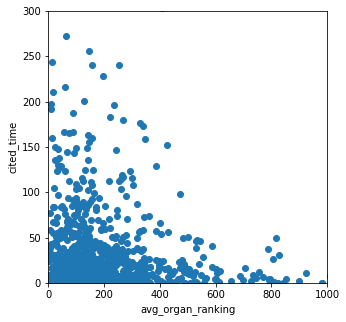

In [41]:
ranking_sub = merged_WOS_df.groupby('avg_organ_ranking').mean()['cited_time'].reset_index()
plt.scatter(x = list(ranking_sub.avg_organ_ranking), y = list(ranking_sub.cited_time))
plt.xlabel('avg_organ_ranking')
plt.ylabel('cited_time on average')
plt.ylim(0, 300)
plt.xlim(0, 1000)
plt.show()

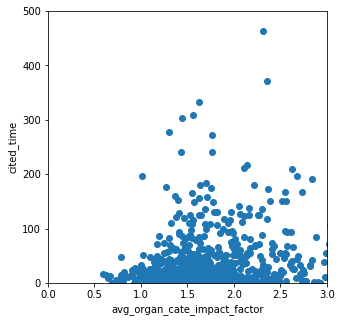

In [42]:
organization_sub = merged_WOS_df.groupby('avg_organ_cate_impact_factor').mean()['cited_time'].reset_index()
plt.scatter(x = list(organization_sub['avg_organ_cate_impact_factor']), y = list(organization_sub['cited_time']))
plt.xlabel('avg_organ_cate_impact_factor')
plt.ylabel('cited_time on average')
plt.ylim(0, 500)
plt.xlim(0, 3)
plt.show()

## 6. Research Field

Although being generated by the business school professors at Imperial College London, the target publications cover the 94 research categories which account for about 41.6% of the total classes defined by the Web of Science. In other words, there might be significantly different impact factors on which research fields a publication covers. Also, the dataset about the research categories is in the panel format, which helped to measure the impact factor during a specified period. Based on matching the research field and published year, the data in the column of the "aggregate impact factor", which is the cited time in two years divided by the number of the items in two years, has been added on average.

In [43]:
cate_df = pd.read_csv('./data/Category.csv')
cate_df = cate_df.replace('Not Available', np.nan)
cate_df = cate_df.dropna(how='any', axis=0)
cate_df.drop(columns = ['page_url' ,'category2', 'edition'], axis = 1).head(5)

,category1,year,journal_num,articles,total_cites,median_impact_factor,aggregate_impact_factor,aggregate_immediacy_index,aggregate_cited_half_life,aggregate_citing_half_life
0,ACOUSTICS,2016.0,31.0,"5,088","160,629",1.547,2.102,0.528,>10.0,9.6
1,ACOUSTICS,2015.0,32.0,"4,916","138,295",1.103,1.853,0.446,9.6,9.6
2,ACOUSTICS,2014.0,31.0,"4,273","125,484",0.912,1.741,0.400,9.6,9.7
3,ACOUSTICS,2013.0,30.0,"4,355","117,073",1.107,1.840,0.357,9.2,9.5
4,ACOUSTICS,2012.0,31.0,"4,139","111,560",1.097,1.710,0.332,9.1,9.5


In [44]:
def list_avg(list_array):
    j = 0.0
    count = 0.0
    for i in list_array:
        j += i
        count += 1
    return j/count

In [45]:
row_line = 0
for cate, yrs in zip(list(merged_WOS_df.WOS_cate), list(merged_WOS_df.published_yrs)):
    sum_avg_cate_impact_factor = 0
    for c in cate:
        try:
            filtered_df = cate_df[cate_df.category1 == c.strip().upper()]
            start = filtered_df.index[0]
            end = filtered_df[filtered_df.year == float(yrs)].index[0]
            aggregate_impact_factor = [float(i) for i in list(filtered_df.loc[start:end,'aggregate_impact_factor'])]
            sum_avg_cate_impact_factor += list_avg(aggregate_impact_factor)
        except:
            filtered_df = cate_df[cate_df.category1 == c.strip().upper()]
            if filtered_df.shape[0] == 0:
                continue
            else:
                start = filtered_df.index[0]
                end = start + filtered_df.shape[0] - 1
                aggregate_impact_factor = [float(i) for i in list(filtered_df.loc[start:end,'aggregate_impact_factor'])]
                sum_avg_cate_impact_factor += list_avg(aggregate_impact_factor)
    merged_WOS_df.loc[row_line, 'avg_research_field_impact_factor'] = sum_avg_cate_impact_factor/len(cate)
    row_line += 1

In [46]:
merged_WOS_df[['Title', 'WOS_cate', 'published_yrs', 'avg_research_field_impact_factor', 'cited_time']].head(5)

,Title,WOS_cate,published_yrs,avg_research_field_impact_factor,cited_time
0,Nelson-Plosser revisited: The ACF approach,"[Economics, Mathematics, Interdisciplinary Ap...",2013,1.401417,5
1,An I(d) model with trend and cycles,"[Economics, Mathematics, Interdisciplinary Ap...",2011,1.362444,5
2,Two estimators of the long-run variance: Beyon...,"[Economics, Mathematics, Interdisciplinary Ap...",2009,1.346792,9
3,Testing joint hypotheses when one of the alter...,"[Economics, Mathematics, Interdisciplinary Ap...",2007,1.318733,24
4,Nonstationarity-extended local Whittle estimation,"[Economics, Mathematics, Interdisciplinary Ap...",2007,1.318733,81


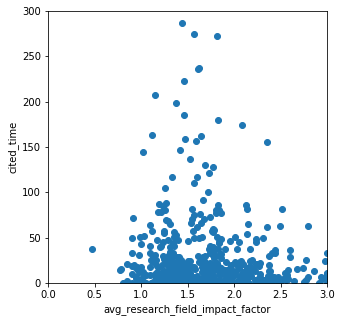

In [47]:
research_sub = merged_WOS_df.groupby('avg_research_field_impact_factor').mean()['cited_time'].reset_index()
plt.scatter(x = list(research_sub['avg_research_field_impact_factor']), y = list(research_sub['cited_time']))
plt.xlabel('avg_research_field_impact_factor')
plt.ylabel('cited_time on average')
plt.xlim(0, 3)
plt.ylim(0, 300)
plt.show()

## 7. Journal

The number of the readers on an article contributing to New York Times would be higher than the one writing for a local newspaper. In other words for publications, the influence or clout of a journal might be the vital indicator to predict the cited time of a paper. In the same way of the "avg_research_field_impact_factor" variable above, the journal impacts factor on average from the published year to the latest year has been created. According to the InCites Indicator Handbook published in 2014 by the Web of Science, journal impact factor is the number of the cited times divided by the items released over the past two years in each journal (InCites INDICATORS HANDBOOK, 2014, p.7).

In [48]:
journal_type = pd.read_csv('./data/Journal_type.csv')
refined_journal_df = journal_type[['journal_type_main_page', 'year', 'journal_impact_factor']]
refined_journal_df = refined_journal_df[refined_journal_df.journal_impact_factor.isnull() == False]
refined_journal_df.head(5)

,journal_type_main_page,year,journal_impact_factor
0,JOURNAL OF ECONOMETRICS,2016,1.633
1,JOURNAL OF ECONOMETRICS,2015,1.611
2,JOURNAL OF ECONOMETRICS,2014,1.600
3,JOURNAL OF ECONOMETRICS,2013,1.533
4,JOURNAL OF ECONOMETRICS,2012,1.710


In [49]:
row_line = 0
for t, yrs in zip(list(merged_WOS_df.journal_type), list(merged_WOS_df.published_yrs)):
    avg_impact_factor = 0
    try:
        filtered_df = refined_journal_df[refined_journal_df.journal_type_main_page == t.split(',')[0].strip().upper()]
        start = filtered_df.index[0] # latest yrs index
        end = filtered_df[filtered_df.year == float(yrs.strip())].index[0]
        journal_impact_factors = [float(i) for i in list(filtered_df.loc[start:end,'journal_impact_factor'])]
        avg_impact_factor += list_avg(journal_impact_factors)
    except:
        filtered_df = refined_journal_df[refined_journal_df.journal_type_main_page ==  t.split(',')[0].strip().upper()]
        if filtered_df.shape[0] == 0:
            merged_WOS_df.loc[row_line, 'avg_journal_impact_factor'] = 0
            row_line += 1
            continue
        else:
            start = filtered_df.index[0]
            end = start + filtered_df.shape[0] - 1
            journal_impact_factors = [float(i) for i in list(filtered_df.loc[start:end,'journal_impact_factor'])]
            avg_impact_factor += list_avg(journal_impact_factors)
    merged_WOS_df.loc[row_line, 'avg_journal_impact_factor'] = avg_impact_factor
    row_line += 1

In [50]:
merged_WOS_df[['Title', 'journal_type', 'published_yrs', 'avg_journal_impact_factor', 'cited_time']].head(5)

,Title,journal_type,published_yrs,avg_journal_impact_factor,cited_time
0,Nelson-Plosser revisited: The ACF approach,JOURNAL OF ECONOMETRICS,2013,1.594250,5
1,An I(d) model with trend and cycles,JOURNAL OF ECONOMETRICS,2011,1.572667,5
2,Two estimators of the long-run variance: Beyon...,JOURNAL OF ECONOMETRICS,2009,1.644125,9
3,Testing joint hypotheses when one of the alter...,JOURNAL OF ECONOMETRICS,2007,1.693300,24
4,Nonstationarity-extended local Whittle estimation,JOURNAL OF ECONOMETRICS,2007,1.693300,81


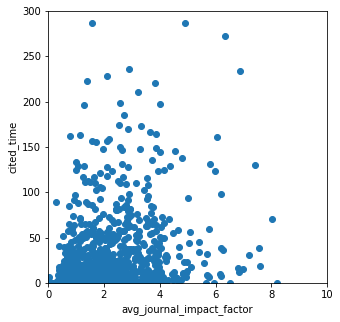

In [51]:
journal_sub = merged_WOS_df.groupby('avg_journal_impact_factor').mean()['cited_time'].reset_index()
plt.scatter(x = list(journal_sub.avg_journal_impact_factor), y = list(journal_sub.cited_time))
plt.xlabel('avg_journal_impact_factor')
plt.ylabel('cited_time on average')
plt.xlim(0, 10)
plt.ylim(0, 300)
plt.show()

## 8. Diversity

### Ethnicity (diversity)

When it comes to diversity, I have divided it into three parts: ethnicity, institution, and organisation country. First of all, based upon the last names of the target authors, their ethnicities can be estimated by using the python package called "ethnicolr." The basic idea of ethnicity is authors with different growth background might look at a topic and solve it differently. In other words, the ethnicity diversity might help to create an environment of thesis-antithesis-synthesis paradigm. So, the dummy variable is created for 1 if multi-ethnicities, otherwise 0.

In [ ]:
from ethnicolr import pred_wiki_ln
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

def df_make(w):
    df = pd.DataFrame()
    df['last_name'] = w
    return df

def list_nested(l):
    k = df_make(l)
    pred_wiki_ln(k, 'last_name')
    return [each.split(',')[0] for each in k.race]

In [ ]:
WOS_df = pd.read_pickle('C:/Users/seong/Documents/00. Summer/1. Workforce/Individual HW/01. Crawling(WebOfScience)/data/final.pkl')
for i in list(np.arange(0, 1495, 16)):
    try:
        df_eth = pd.read_pickle('./data/ethnictity_df.pkl')
    except:
        df_eth = pd.DataFrame(columns = ['names', 'ethnicity'])
    if df_eth.shape[0] > i:            #df = 235 > i=250
        print("DONE", df_eth.shape[0])
        continue
    else:
        start = df_eth.shape[0]
        end = i
        for j in WOS_df.co_author1[start:end]:
            row_sc = df_eth.shape[0]
            df_eth.loc[row_sc, 'names'] = j
            df_eth.loc[row_sc, 'ethnicity'] = list_nested(j)
            print("%dth. %s, %s" %(row_sc+1, df_eth.loc[row_sc, 'names'], df_eth.loc[row_sc, 'ethnicity']))
            df_eth.to_pickle('./data/ethnictity_df.pkl')

In [54]:
ethnicity = pd.read_pickle('./data/ethnictity_df.pkl')
merged_WOS_df['ethnicity'] = ethnicity['ethnicity']

In [55]:
merged_WOS_df['multi_eth_dummy'] = merged_WOS_df['ethnicity'].apply(lambda x: 0 if len(list(set(x))) == 1 else 1)

In [56]:
merged_WOS_df.multi_eth_dummy.value_counts()

0    1165
1     256
Name: multi_eth_dummy, dtype: int64

In [59]:
eth_sub = merged_WOS_df.groupby('multi_eth_dummy').mean()['cited_time'].reset_index()
eth_sub.eth_diversity = eth_sub.multi_eth_dummy.round(2)
eth_sub.cited_time = eth_sub.cited_time.round(2)
eth_sub.index = eth_sub.eth_diversity
eth_sub = eth_sub['cited_time']
eth_sub.head

<bound method NDFrame.head of multi_eth_dummy
0    37.55
1    40.59
Name: cited_time, dtype: float64>

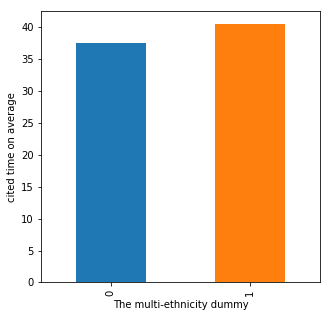

In [122]:
eth_sub.plot(kind = 'bar')
plt.xlabel('The multi-ethnicity dummy')
plt.ylabel('cited time on average')
plt.show()

### Organization Country (diversity)

In the dataset, most of the organisations of the co-author's groups are from one or two countries. The diversity of organisation is related to building a generalised theory. For example, it might be harder for a group of authors at Imperial College London to generalise a method to be able to be applied to not only England but also other countries due to exceptional cases not happening in England. However, a publication written by a group of authors based in different countries would be proven more broadly, which might lead to a more significant article. So, the dummy variable is created for 1 if multi-countries, otherwise 0.

In [62]:
merged_WOS_df['num_country_set'] = merged_WOS_df['organ_country'].apply(lambda x: len(list(set(x)))) 

In [63]:
print("number of Country in set on count")
merged_WOS_df.num_country_set.value_counts()

number of Country in set on count


1     720
2     441
3     164
4      62
5      15
7       4
6       4
12      3
11      3
10      2
15      1
13      1
8       1
Name: num_country_set, dtype: int64

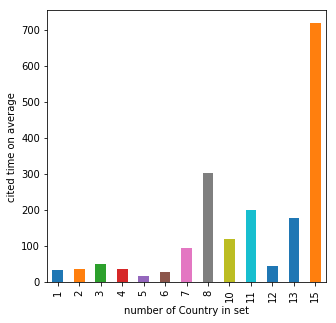

In [121]:
merged_WOS_df.groupby('num_country_set').mean()['cited_time'].plot(kind = 'bar')
plt.xlabel('number of Country in set')
plt.ylabel('cited time on average')
plt.show()

In [65]:
for i, num in enumerate(list(merged_WOS_df['num_country_set'])):
    if num == 1:
        merged_WOS_df.loc[i, 'organ_multi_country_dummy'] = 0
    else:
        merged_WOS_df.loc[i, 'organ_multi_country_dummy'] = 1

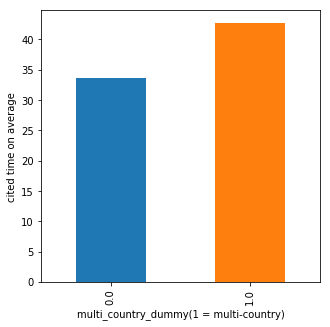

In [116]:
merged_WOS_df.groupby('organ_multi_country_dummy').mean()['cited_time'].plot(kind = 'bar')
plt.xlabel('multi_country_dummy(1 = multi-country)')
plt.ylabel('cited time on average')
plt.show()

In [68]:
merged_WOS_df[['Title', 'ethnicity', 'multi_eth_dummy', 'organ_country', 'num_country_set', 'organ_multi_country_dummy']].head(5)

,Title,ethnicity,multi_eth_dummy,organ_country,num_country_set,organ_multi_country_dummy
0,Nelson-Plosser revisited: The ACF approach,"[GreaterAfrican, GreaterEuropean, GreaterEurop...",1,"[SCOTLAND, ENGLAND, ENGLAND, ITALY]",3,1.0
1,An I(d) model with trend and cycles,"[GreaterAfrican, GreaterEuropean, GreaterEurop...",1,"[ENGLAND, ENGLAND]",1,0.0
2,Two estimators of the long-run variance: Beyon...,"[GreaterAfrican, GreaterEuropean, GreaterEurop...",1,"[ENGLAND, ENGLAND]",1,0.0
3,Testing joint hypotheses when one of the alter...,"[GreaterAfrican, GreaterEuropean]",1,[ENGLAND],1,0.0
4,Nonstationarity-extended local Whittle estimation,"[GreaterAfrican, GreaterEuropean, GreaterEurop...",1,"[ENGLAND, ENGLAND]",1,0.0


### Institution (diversity)

Finally, regarding institution diversity, it would be critical if, in a group of multiple organisations, each has a stronger academic field than one another.  As a result, a publication with a university diversity might have higher uniqueness enhanced by fusion research. So, the dummy variable is created for 1 if multi-institutions, otherwise 0.

In [69]:
merged_WOS_df['num_uni_set'] = merged_WOS_df['organization'].apply(lambda x: len(list(set(x)))) 

In [70]:
print("number of Country in set by count")
merged_WOS_df.num_uni_set.value_counts()

number of Country in set by count


1     466
2     382
3     265
4     147
5      71
6      42
7      18
8       9
9       5
12      3
16      2
10      1
50      1
30      1
13      1
15      1
19      1
21      1
22      1
23      1
25      1
11      1
Name: num_uni_set, dtype: int64

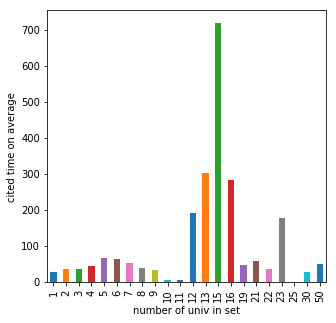

In [120]:
merged_WOS_df.groupby('num_uni_set').mean()['cited_time'].plot(kind = 'bar')
plt.xlabel('number of univ in set')
plt.ylabel('cited time on average')
plt.show()

In [72]:
for i, num in enumerate(list(merged_WOS_df['num_uni_set'])):
    if num == 1:
        merged_WOS_df.loc[i, 'multi_univ_dummy'] = 0
    else:
        merged_WOS_df.loc[i, 'multi_univ_dummy'] = 1

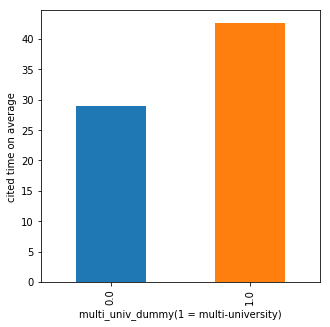

In [117]:
merged_WOS_df.groupby('multi_univ_dummy').mean()['cited_time'].plot(kind = 'bar')
plt.xlabel('multi_univ_dummy(1 = multi-university)')
plt.ylabel('cited time on average')
plt.show()

## 9. Take the log to the cited time

In [74]:
merged_WOS_df['log_cited_time'] = merged_WOS_df['cited_time'].apply(lambda x: math.log(x+1))

## 10. Title+Keywords similar to Abstract

From the information search perspective, it is crucial to set the right titles and keywords for a publication because the publication is more likely to be shown on the top search result. Furthermore, if the title and keywords are highly similar to the abstract, readers would continue to look into the publication. The formula for measuring the similarity is the intersect of two lists divided by the union of the two lists. One list consists of the words of a title and keywords from a publication. The other list is made up of the words of an abstract from the same paper.

In [75]:
import nltk

def extract_nouns(text):
    # use tokenizer to split text into individual words
    words = nltk.word_tokenize(text)    
    # use tagger to categorize all words
    tags = nltk.pos_tag(words)
    # keep nouns only (nn, nns, nnp, nnps)
    only_nouns = []
    for word, pos in tags: 
        if (pos == 'NN' or pos == 'NNS' or pos == 'NNP' or pos == 'NNPS'):
            only_nouns.append(word.lower())
    return only_nouns  

def intersect(a, b):
    return list(set(a) & set(b))
def union (a,b):
    return  list(set(a).union(b))
       
def similarity(lst1, lst2):
    numerator =  len(intersect(lst1,lst2))
    denom = len(union(lst1,lst2))
    if not denom:
        sim = 0
    else:
        sim = round(float(numerator)/denom,3)
    return sim   

In [76]:
df = merged_WOS_df.copy()
df.dropna(axis=0, how='any', inplace=True)

In [77]:
sim_list = []
for idx in range(len(df)):
    title_keyword = extract_nouns(list(df.Title)[idx])+[i.lower() for i in list(df.keywords)[idx]]
    abstract_nouns = extract_nouns(list(df.abstract)[idx])
    sim_list.append(similarity(title_keyword, abstract_nouns))
df['sim'] = sim_list

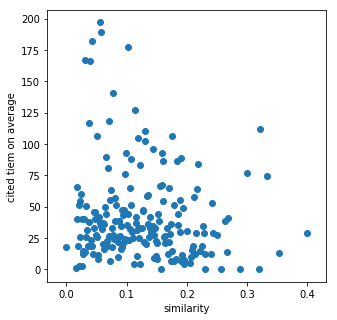

In [119]:
sim_sub = df.groupby('sim').mean()['cited_time'].reset_index()
plt.scatter(x = list(sim_sub.sim), y = list(sim_sub.cited_time))
plt.ylabel('cited tiem on average')
plt.xlabel('similarity')
plt.show()

In [79]:
keyword_dummy = []
for i, j in enumerate(list(df.keywords)):
    if len(j) > 0:
        keyword_dummy.append(int(1))
    else:
        keyword_dummy.append(int(0))
df['keyword_provided_dummy'] = keyword_dummy

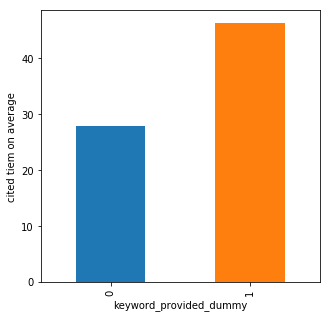

In [118]:
df.groupby('keyword_provided_dummy').mean()['cited_time'].plot(kind = 'bar')
plt.ylabel('cited tiem on average')
plt.show()

## 11. Preprocessing and Feature Engineering Result

Throughout the preprocessing and feature engineering, 15 independent variables have been created for the 1,160 data lines. The descriptions of each predictor are as following:

1. **yrs_since_published**: year pass since published. ex) published year: 2018 -> yrs_since_published: 1
2. **co_author_num**: the number of the co-authors
3. **avg_authors_h_index**: authors' h-index on average
4. **sim**: similarity between title+keywords and abstract
5. **num_of_ref**: the number of the references for a target publication
6. **ref_yearly_cited_avg**: the cited time of the references on average for a target publication
7. **avg_organ_ranking**: a mean of the ranking of the organisations in the relevant research categories
8. **avg_organ_cate_impact_factor**: a mean of the category impact factor in the relevant research categories
9. **avg_research_field_impact_factor**: a mean of impact factor in the relevant research categories
10. **avg_journal_impact_factor**: a mean of impact factor in the relevant journal
11. **multi_eth_dummy**: 1 if the number of authors' ethnicities is above 1. Otherwise, 0.
12. **organ_multi_country_dummy**: 1 if the number of organisations' countries is above 1. Otherwise, 0.
13. **multi_univ_dummy**: 1 if the number of organisations is over 1. Otherwise, 0.
14. **author_odd_num_dummy**: 1 if the number of co-authors is odd and greater than 1. Otherwise, 0.
15. **keyword_provided_dummy**: 1 if keywords are provided. Otherwise, 0.

In [81]:
df.to_pickle('./data/preprocessed_df.pkl')

In [82]:
preprocessed_df = pd.read_pickle('./data/preprocessed_df.pkl')
final_df = preprocessed_df[['log_cited_time', 'cited_time', 'yrs_since_published',\
               'co_author_num','avg_authors_h_index', 'author_odd_num_dummy',\
               'num_of_ref', 'ref_yearly_cited_avg', \
               'avg_organ_ranking', 'avg_organ_cate_impact_factor',\
               'avg_research_field_impact_factor', 'avg_journal_impact_factor',\
               'multi_eth_dummy', 'organ_multi_country_dummy','multi_univ_dummy', 'sim', 'keyword_provided_dummy']]
final_df.head(5)

,log_cited_time,cited_time,yrs_since_published,co_author_num,avg_authors_h_index,author_odd_num_dummy,num_of_ref,ref_yearly_cited_avg,avg_organ_ranking,avg_organ_cate_impact_factor,avg_research_field_impact_factor,avg_journal_impact_factor,multi_eth_dummy,organ_multi_country_dummy,multi_univ_dummy,sim,keyword_provided_dummy
0,1.791759,5,6,3,6.333333,1,42,18.801852,224.888889,1.106667,1.401417,1.594250,1,1.0,1.0,0.021,1
1,1.791759,5,8,3,7.333333,1,22,3.940034,55.000000,1.478333,1.362444,1.572667,1,0.0,1.0,0.036,1
2,2.302585,9,10,3,7.333333,1,21,26.560935,55.000000,1.478333,1.346792,1.644125,1,0.0,1.0,0.093,1
3,3.218876,24,12,2,6.000000,0,58,10.841103,103.333333,1.310000,1.318733,1.693300,1,0.0,0.0,0.042,1
4,4.406719,81,12,3,4.333333,1,21,6.388188,55.000000,1.478333,1.318733,1.693300,1,0.0,1.0,0.051,1


In [83]:
final_df.to_pickle('./data/final_df.pkl')

# Model Building

This section is divided into four parts: 1. Multicollinearity, 2. Feature Selection, 3. Model Evaluation, and 4. Model interpretation. As shown on the scatter plot, the data points seem like the exponential distribution, which describes that a majority of the dataset is skewed to the left side. There are multiple modelling options such as negative binomial regression(NB regression), Poisson regression, or linear regression with taking the log of the target variable especially for the dependent variable like the number of event occurrence. The linear regression and NB regression will be executed for the analysis.

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.compat import lzip
from statsmodels.graphics.gofplots import ProbPlot

%matplotlib inline

final_df = pd.read_pickle('./data/final_df.pkl')

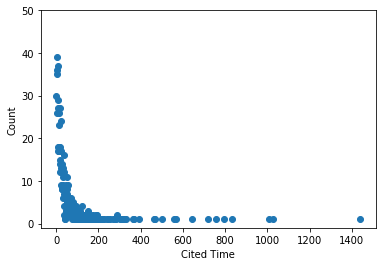

In [7]:
df_sub = final_df.cited_time.value_counts().reset_index()
df_sub = df_sub.rename(columns={'index':'cited_time', 'cited_time':'count'})
df_sub = df_sub.sort_values(by='cited_time')
plt.scatter(list(df_sub['cited_time']),  list(df_sub['count']))
plt.xlabel('Cited Time')
plt.ylabel('Count')
plt.ylim([-1, 50])
plt.show()

## 1. Multicollinearity

Multicollinearity can cause misinterpreting the effect of the independent variables in the models. The best way to solve the issue is removing the variables above the variance inflation factor(VIF) of 10 and highly correlated variables. By using the function "variance_inflation_factor" in the statesmodels package, the VIF was calculated. As a result, there are two variables above the VIF of 10, which are "avg_organ_cate_impact_factor", and "keyword_dummy". Also, as depicted in the heatmap, "organ_multi_country_dummy " is highly correlated to the "multi_univ_dummy," which indicates that one of them should be removed.

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [9]:
X = final_df.drop(columns = ['log_cited_time', 'cited_time'], axis = 1)
y = final_df['log_cited_time']

for i in range(X.shape[1]):
    vif = variance_inflation_factor(X.values, i)
    print(X.columns[i],':',vif)

yrs_since_published : 3.997447319380111
co_author_num : 2.864829695635063
avg_authors_h_index : 3.795788677467461
author_odd_num_dummy : 1.8102751517290039
num_of_ref : 4.640406118280451
ref_yearly_cited_avg : 2.8000231186393525
avg_organ_ranking : 2.02838262519188
avg_organ_cate_impact_factor : 15.06658017224891
avg_research_field_impact_factor : 8.882470075780404
avg_journal_impact_factor : 2.1364451343072015
multi_eth_dummy : 1.3561868995864284
organ_multi_country_dummy : 3.5769501865987174
multi_univ_dummy : 5.678103087472005
sim : 4.8173420037466625
keyword_provided_dummy : 11.721756285530237


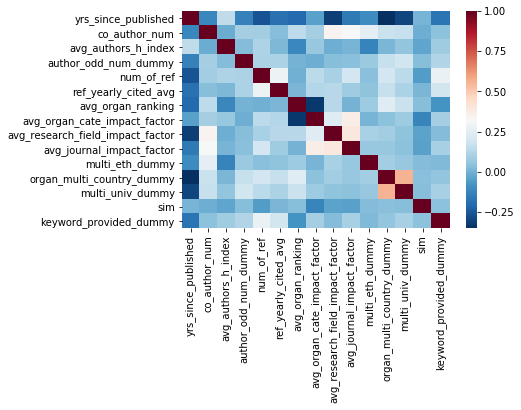

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_df = X.corr()
sns.heatmap(corr_df, cmap='RdBu_r')
plt.show()

## 2. Feature Selection

The Random Forest(RF) will be used to select the predictors by measuring the feature importance. To find out the best hyper-parameters of the RF models, the grid search method has been applied with the cross-validation of k = 20. As a result, the optimal model has built on the max feature = 7 and the number of estimators = 550. The results of Random Forest Regression with log(cited_time) as target variable shows that "yrs_since_published", "avg_journal_impact_factor", "avg_authors_h_index", and "num_of_ref" are the top 4 important variables as below. Based on the previous VIF, correlation heatmap, and the current RF feature importance, the three feature groups has been formulated as below.

1. all varaibles group : 15 variables
2. truncated group 1: 13 variables (dropped variables: "avg_organ_cate_impact_factor", "keyword_provided_dummy")
3. truncated group 2: 12 variables (dropeed variables: "avg_organ_cate_impact_factor", "keyword_provided_dummy", "ulti_univ_dummy")

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [12]:
# adding dep_var to employees_final2
X = final_df.drop(columns = ['log_cited_time', 'cited_time'], axis = 1)
y = final_df['log_cited_time']
                                
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [13]:
kfold = KFold(n_splits=20, shuffle=True, random_state=1234)
scoring='neg_mean_squared_error'
n_jobs=-1

model = RandomForestRegressor()
param = {
    'n_estimators': [50, 150, 250, 350, 450, 550, 650],
    'max_features': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
}

In [14]:
gridsearch = GridSearchCV(estimator=model, param_grid=param, cv=kfold, scoring=scoring, n_jobs=n_jobs)
grid_result = gridsearch.fit(X_train, y_train)
print("Best neg_mean_squared_error: %f \nParameters %s" % (grid_result.best_score_, grid_result.best_params_))

Best neg_mean_squared_error: -0.823752 
Parameters {'max_features': 7, 'n_estimators': 350}


In [15]:
fine_tuned_scaled_rf = grid_result.best_estimator_
y_train_hat = fine_tuned_scaled_rf.predict(X_train)
y_test_hat = fine_tuned_scaled_rf.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_hat))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_hat))
r2_train = fine_tuned_scaled_rf.score(X_train, y_train)
r2_test = fine_tuned_scaled_rf.score(X_test, y_test)

print("RMSE Train:",rmse_train)
print("RMSE Test:",rmse_test)

print("R^2 Train:",r2_train)
print("R^2 test:",r2_test)

RMSE Train: 0.33891408349800506
RMSE Test: 0.8439024427938792
R^2 Train: 0.9478642544169114
R^2 test: 0.6079395469371554


1 . yrs_since_published 0.3767010359138984
2 . avg_journal_impact_factor 0.18719259375100566
3 . avg_authors_h_index 0.06975799862154546
4 . num_of_ref 0.06861299264582943
5 . ref_yearly_cited_avg 0.05548434143561269
6 . avg_research_field_impact_factor 0.053871294301798885
7 . avg_organ_ranking 0.05051894646916962
8 . avg_organ_cate_impact_factor 0.050221809496636606
9 . sim 0.03750362942898445
10 . co_author_num 0.02728085676319699
11 . keyword_provided_dummy 0.004837643580024465
12 . author_odd_num_dummy 0.004735866968050322
13 . organ_multi_country_dummy 0.004626672717495975
14 . multi_eth_dummy 0.004621405847028454
15 . multi_univ_dummy 0.004032912059722542


Text(0.5,1,'Results of Random Forest Regression with log(cited_time) as target variable')

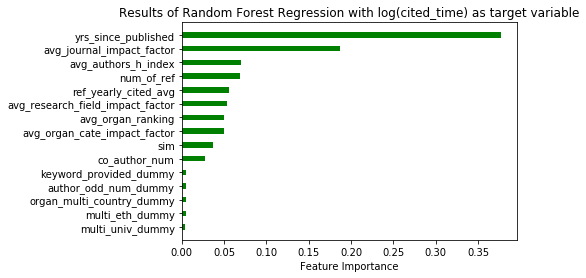

In [16]:
# Sorting features by their score
features, importances = zip(*sorted(zip(list(X.columns), fine_tuned_scaled_rf.feature_importances_), key=lambda x: x[1], reverse=True))

# Printing out the results 
num = 0
for f, i in zip(features, importances):
    num += 1
    print(num,".", f, i)

# Sorting features by their score
features, importances = zip(*sorted(zip(list(X.columns), fine_tuned_scaled_rf.feature_importances_), key=lambda x: x[1]))
    
# Creating pos, a list containing indexes of unknown_by_yr
yPos = range(len(features))
       
# Plotting the horizontal bar chart
plt.barh(yPos,  importances,  height = 0.4, color='green') 

# Setting xticks to have the same `pos` as bars 
plt.yticks(yPos, features)

# Setting xlabel
plt.xlabel('Feature Importance')

#  Setting a title, and axes labels
plt.title('Results of Random Forest Regression with log(cited_time) as target variable')

In [17]:
def remove_all_high_VIF(df, predictors, threshold=10):        
    columns = predictors
    df = df[columns].copy()
    
    dropped = True
    while dropped:
        dropped = False
        vif_vals = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]        
        max_vif = max(vif_vals)
        if max_vif > threshold:
            max_vif_index = vif_vals.index(max_vif)
            print('Dropped:',columns[max_vif_index],max_vif)
            del columns[max_vif_index]
            df = df[columns]
            dropped = True

    predictors = columns
    return predictors

In [18]:
trunc_columns = remove_all_high_VIF(final_df, list(X.columns))
f = final_df[trunc_columns]
print("\n")
print("=== VIF values ===")
count = 0
for i in range(f.shape[1]):
    count +=1
    vif = variance_inflation_factor(f.values, i)
    print(count, ".", f.columns[i],':', vif)

Dropped: avg_organ_cate_impact_factor 15.06658017224891
Dropped: keyword_provided_dummy 10.64393346348787


=== VIF values ===
1 . yrs_since_published : 3.1769529855355167
2 . co_author_num : 2.8561197339633115
3 . avg_authors_h_index : 3.7167972032551826
4 . author_odd_num_dummy : 1.7908258862605662
5 . num_of_ref : 4.083382643964661
6 . ref_yearly_cited_avg : 2.7243509861895765
7 . avg_organ_ranking : 1.8842108283439634
8 . avg_research_field_impact_factor : 6.825378636727521
9 . avg_journal_impact_factor : 2.026584228779414
10 . multi_eth_dummy : 1.3537412761622312
11 . organ_multi_country_dummy : 3.5489128900897686
12 . multi_univ_dummy : 5.286835384005624
13 . sim : 4.4636291944199264


In [19]:
# drop multi_univ_dummy due to high correlation
trunc_columns2 = ['yrs_since_published', 'co_author_num', 'avg_authors_h_index', 'author_odd_num_dummy', 'num_of_ref', 'ref_yearly_cited_avg', 'avg_organ_ranking', 'avg_research_field_impact_factor','avg_journal_impact_factor', 'multi_eth_dummy', 'organ_multi_country_dummy', 'sim']
print("Dropped: multi_univ_dummy\n")
print("=== VIF values ===")

f = final_df[trunc_columns2]
count = 0
for i in range(f.shape[1]):
    count +=1
    vif = variance_inflation_factor(f.values, i)
    print(count, ".", f.columns[i],':',vif)

Dropped: multi_univ_dummy

=== VIF values ===
1 . yrs_since_published : 3.172121029379101
2 . co_author_num : 2.83857820890064
3 . avg_authors_h_index : 3.6506820972662752
4 . author_odd_num_dummy : 1.7585673606493974
5 . num_of_ref : 4.053885638663706
6 . ref_yearly_cited_avg : 2.722150773135011
7 . avg_organ_ranking : 1.8718493425608902
8 . avg_research_field_impact_factor : 6.758335160242326
9 . avg_journal_impact_factor : 2.0246635781697107
10 . multi_eth_dummy : 1.3534748977417483
11 . organ_multi_country_dummy : 2.650322541475432
12 . sim : 4.38417349836744


## 3-1. Model Evaluation (Linear Regression)

To compare the three models' performance, the dataset is split into 80% of the trainset and 20% of the testset. For the regression model trained with all of the variables, the adjusted R square is 0.40, and the Root Mean Square Error(RMSE) is 1.10, which are the best among the three models. The results of the other two regressors have similar to each other, which is the adjusted R square of 0.38 and the RMSE of 1.10. Regarding interpretation, it is essential to select an unbiased model which satisfies the Gauss-Markov theorem. Therefore, the last model with the 12 features has been chosen to interpret the casual effects.

In [20]:
# Regression using all variables
from sklearn.metrics import mean_squared_error

# Regression using all variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train = sm.add_constant(X_train) #intercept added
X_test = sm.add_constant(X_test)

# fit the model onto the training sample
model = sm.OLS(y_train, X_train).fit()
y_hat = model.predict(X_test) # make the predictions by the model
rmse_full =  np.sqrt(mean_squared_error(y_test, y_hat))

# Regression using truncated variables (1)
X_train, X_test, y_train, y_test = train_test_split(X[trunc_columns], y, test_size = 0.2, random_state = 123)
X_train = sm.add_constant(X_train) #intercept added
X_test = sm.add_constant(X_test)

model_trunc1 = sm.OLS(y_train, X_train).fit()
y_hat_trunc1 = model_trunc1.predict(X_test) # make the predictions by the model
rmse_trunc1 =  np.sqrt(mean_squared_error(y_test, y_hat_trunc1))

# Regression using truncated variables (2)
X_train, X_test, y_train, y_test = train_test_split(X[trunc_columns2], y, test_size = 0.2, random_state = 123)
X_train = sm.add_constant(X_train) #intercept added
X_test = sm.add_constant(X_test)

model_trunc2 = sm.OLS(y_train, X_train).fit()
y_hat_trunc2 = model_trunc2.predict(X_test) # make the predictions by the model
rmse_trunc2 =  np.sqrt(mean_squared_error(y_test, y_hat_trunc2))


print("=== Full Model Performance in testset ===")
print("Adjusted R2 for the full model is: %s"  %(round(model.rsquared_adj, 5)))
print("RMSE for the full model is: %s\n" %(round(rmse_full, 5)))

print("=== Truncated Model 1 Performance in testset ===")
print("Adjusted R2 for the truncated model is: %s" %(round(model_trunc1.rsquared_adj, 5)))
print("RMSE for the truncated model is: %s\n" %(round(rmse_trunc1, 5)))

print("=== Truncated Model 2 Performance in testset(trunc1+'organ_country_diversity' dropped) ===")
print("Adjusted R2 for the truncated model is: %s" %(round(model_trunc2.rsquared_adj, 5)))
print("RMSE for the truncated model is: %s" %(round(rmse_trunc2, 5)))

=== Full Model Performance in testset ===
Adjusted R2 for the full model is: 0.40068
RMSE for the full model is: 1.09659

=== Truncated Model 1 Performance in testset ===
Adjusted R2 for the truncated model is: 0.389
RMSE for the truncated model is: 1.10288

=== Truncated Model 2 Performance in testset(trunc1+'organ_country_diversity' dropped) ===
Adjusted R2 for the truncated model is: 0.38644
RMSE for the truncated model is: 1.10675


In [21]:
from statsmodels.iolib.summary2 import summary_col
linear_reg = summary_col([model, model_trunc1, model_trunc2],stars=True)
print(linear_reg)


                                 log_cited_time I log_cited_time II log_cited_time III
--------------------------------------------------------------------------------------
author_odd_num_dummy             0.0945           0.1090            0.1265            
                                 (0.0786)         (0.0789)          (0.0787)          
avg_authors_h_index              0.0141***        0.0154***         0.0161***         
                                 (0.0032)         (0.0033)          (0.0033)          
avg_journal_impact_factor        0.0766***        0.0873***         0.0874***         
                                 (0.0144)         (0.0137)          (0.0138)          
avg_organ_cate_impact_factor     0.1758*                                              
                                 (0.0947)                                             
avg_organ_ranking                -0.0007***       -0.0008***        -0.0008***        
                                 (0.0002) 

### 3-2. Negative Binomial Regression

In [5]:
NB_reg = smf.glm(formula = "cited_time ~ yrs_since_published + co_author_num + avg_authors_h_index + author_odd_num_dummy + num_of_ref + ref_yearly_cited_avg + avg_organ_ranking + avg_research_field_impact_factor + avg_journal_impact_factor + multi_eth_dummy + organ_multi_country_dummy+sim", data=final_df, family=sm.families.NegativeBinomial()).fit()

## 3-3. Model Interpretation

Due to the difference of the dependent variables between the linear regression and negative binomial regression, the two models' performance cannot be compared. However, given the dependent variable is a count of event occurrence, the negative binomial regression is a more proper model to infer in this case. <br>
Above all, the journal impact factor is statistically and economically significant at the 95% confident interval, which indicates that the higher a journal has an impact factor, the more chances a publication gets to be cited. And the period of being published has a positive effect on the cited time, which demonstrates that every ten years passed after the publishment will give a chance for the 15% increase of the citation. When it comes to the author's performance, the number of co-authors is more important than the average h-index of the co-authors in that both are statistically significant at the 95% confident interval.  For the reference, citing publications with high citation is more important than citing more publications, which refers to the significance of the quality-oriented citing. The other variables are insignificant or not economical in the regression model.

In [6]:
NB_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             cited_time   No. Observations:                 1160
Model:                            GLM   Df Residuals:                     1147
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    log   Scale:              1.3200350628214976
Method:                          IRLS   Log-Likelihood:                -5059.9
Date:                Sun, 24 Jun 2018   Deviance:                       1488.2
Time:                        23:15:14   Pearson chi2:                 1.51e+03
No. Iterations:                    70                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.2542      0.182      1.397      0.162      -0.102       0.611
yrs_since_published                  0.1541      0.007     23.350      0.000       0.141       0.167
co_author_num                        0.0547      0.013      4.247      0.000       0.029       0.080
avg_authors_h_index                  0.0117      0.003      3.818      0.000       0.006       0.018
author_odd_num_dummy                 0.1192      0.072      1.645      0.100      -0.023       0.261
num_of_ref                           0.0093      0.001      7.383      0.000       0.007       0.012
ref_yearly_cited_avg                 0.0122      0.002      5.325      0.000       0.008       0.017
avg_organ_ranking                   -0.0009      0.000     -5.112      0.000      -0.001      -0.001
avg_research_field_impact_factor     0.0134      0.059      0.229      0.819      -0.102       0.128
avg_journal_impact_factor            0.1733      0.012     14.222      0.000       0.149       0.197
multi_eth_dummy                     -0.0298      0.093     -0.320      0.749      -0.212       0.153
organ_multi_country_dummy            0.1244      0.078      1.588      0.112      -0.029       0.278
sim                                  0.5889      0.648      0.908      0.364      -0.682       1.860
====================================================================================================
"""

# Limitation

The dataset only consists of the publication's information at the whole business school of Imperial College London. It would be much reliable if the specific department names as a dummy variable are included because Finance, Innovation and Entrepreneurship, and Management could have different impact factors regarding journal or research field. Secondly, the reference can be analysed deeper in a way to measure the similarity between each publication title and reference titles, which is a hypothesis that the less similar a title to the reference titles, the more unique the publication could be. However, that could not be executed because some of the reference titles are not provided in the Web of Science.

# Reference

Aksnes, D. (2003). Characteristics of highly cited papers. Research Evaluation, 12(3), pp.159-170.

Ale Ebrahim, N., Salehi, H., Amin Embi, M., Habibi Tanha, F., Gholizadeh, H., Motahar, S. and Ordi, A. (2013). Effective Strategies for Increasing Citation Frequency. International Education Studies, 6(11).

Corbyn, Z. (2010). An easy way to boost a paper's citations. [online] Nature. Available at: https://www.nature.com/news/2010/100813/full/news.2010.406.html [Accessed 21 Jun. 2018].

InCites INDICATORS HANDBOOK. (2014). [ebook] Thomson Reuters, p.7&11. Available at: http://ipscience-help.thomsonreuters.com/inCites2Live/8980-TRS/version/default/part/AttachmentData/data/InCites-Indicators-Handbook-6%2019.pdf [Accessed 20 Jun. 2018].

Menon, T. and Phillips, K. (2011). Getting Even or Being at Odds? Cohesion in Even- and Odd-Sized Small Groups. Organization Science, 22(3), pp.738-753.


# Appendix

## NB Regression vs. Poisson Regression (Similar Result)

In [14]:
from statsmodels.iolib.summary2 import summary_col
Poisson_reg = smf.glm(formula = "cited_time ~ yrs_since_published + co_author_num + avg_authors_h_index + author_odd_num_dummy + num_of_ref + ref_yearly_cited_avg + avg_organ_ranking + avg_research_field_impact_factor + avg_journal_impact_factor + multi_eth_dummy + organ_multi_country_dummy+sim", data=final_df, family=sm.families.Poisson()).fit()
NB_Poisson = summary_col([NB_reg, Poisson_reg],stars=True)
print("          cited_time I(NB Regression)     vs.     cited_time II(Poisson Regression)")
print(NB_Poisson)

          cited_time I(NB Regression)     vs.     cited_time II(Poisson Regression)

                                 cited_time I cited_time II
-----------------------------------------------------------
Intercept                        0.2542       1.2861***    
                                 (0.1820)     (0.0294)     
yrs_since_published              0.1541***    0.1077***    
                                 (0.0066)     (0.0008)     
co_author_num                    0.0547***    0.0338***    
                                 (0.0129)     (0.0011)     
avg_authors_h_index              0.0117***    0.0182***    
                                 (0.0031)     (0.0004)     
author_odd_num_dummy             0.1192       0.1130***    
                                 (0.0725)     (0.0092)     
num_of_ref                       0.0093***    0.0099***    
                                 (0.0013)     (0.0001)     
ref_yearly_cited_avg             0.0122***    0.0191***    
               